In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import json

In [2]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
pd.set_option('display.max_columns', None)

In [3]:
with open('../config/lyft_conection.json', 'r') as file:
    credenciales_lyft = json.load(file)

engine = create_engine(f"mysql+pymysql://{credenciales_lyft['USERNAME']}:{credenciales_lyft['PASSWORD']}@{credenciales_lyft['SERVER']}/{credenciales_lyft['DATABASE']}")

In [4]:
start_date = '2024-01-01 00:00:00'
end_date = '2025-12-31 23:59:59'

In [5]:
sql_BikeRentalFact = f'''

SELECT 
    id,
    creationTimeMs,
    member_birthday
FROM BikeRentalFact
WHERE 
	creationTimeMs BETWEEN UNIX_TIMESTAMP(CONVERT_TZ("{start_date}", "America/Mexico_City", 'UTC'))*1000
    AND UNIX_TIMESTAMP(CONVERT_TZ("{end_date}", "America/Mexico_City", 'UTC'))*1000;

'''

df_sql_BikeRentalFact = pd.read_sql(sql_BikeRentalFact, engine)
df_sql_BikeRentalFact.head()

,id,creationTimeMs,member_birthday
0,14281540,1704088913624,6.401592e+11
1,14281541,1704088937791,7.572312e+11
2,14281542,1704089070784,3.995352e+11
3,14281543,1704089083558,8.432856e+11
4,14281544,1704089085754,8.277336e+11


In [8]:
# convertir fecha de creación a formato datetime
df_sql_BikeRentalFact['creationDate'] = pd.to_datetime(df_sql_BikeRentalFact['creationTimeMs'], unit='ms')
df_sql_BikeRentalFact['birthday'] = pd.to_datetime(df_sql_BikeRentalFact['member_birthday'], unit='ms')
# extraer año
df_sql_BikeRentalFact['year'] = df_sql_BikeRentalFact['creationDate'].dt.year
# extraer mes
df_sql_BikeRentalFact['month'] = df_sql_BikeRentalFact['creationDate'].dt.month
df_sql_BikeRentalFact.head()

,id,creationTimeMs,member_birthday,creationDate,year,month,birthday
0,14281540,1704088913624,6.401592e+11,2024-01-01 06:01:53.624,2024,1,1990-04-15 06:00:00
1,14281541,1704088937791,7.572312e+11,2024-01-01 06:02:17.791,2024,1,1993-12-30 06:00:00
2,14281542,1704089070784,3.995352e+11,2024-01-01 06:04:30.784,2024,1,1982-08-30 06:00:00
3,14281543,1704089083558,8.432856e+11,2024-01-01 06:04:43.558,2024,1,1996-09-21 06:00:00
4,14281544,1704089085754,8.277336e+11,2024-01-01 06:04:45.754,2024,1,1996-03-25 06:00:00


In [9]:
# calcular edad
df_sql_BikeRentalFact['age'] = (pd.to_datetime('now') - df_sql_BikeRentalFact['birthday']).dt.days // 365
df_sql_BikeRentalFact.head()

,id,creationTimeMs,member_birthday,creationDate,year,month,birthday,age
0,14281540,1704088913624,6.401592e+11,2024-01-01 06:01:53.624,2024,1,1990-04-15 06:00:00,35.0
1,14281541,1704088937791,7.572312e+11,2024-01-01 06:02:17.791,2024,1,1993-12-30 06:00:00,31.0
2,14281542,1704089070784,3.995352e+11,2024-01-01 06:04:30.784,2024,1,1982-08-30 06:00:00,43.0
3,14281543,1704089083558,8.432856e+11,2024-01-01 06:04:43.558,2024,1,1996-09-21 06:00:00,29.0
4,14281544,1704089085754,8.277336e+11,2024-01-01 06:04:45.754,2024,1,1996-03-25 06:00:00,29.0


In [ ]:
# segmentar por edad Niño/Adolescente < 17, Joven Adulto (Estudiante) 18-24, Adulto 25-64, Adulto Mayor 65+
def age_group(age):
    if age < 18:
        return 'Niño/Adolescente'
    elif 18 <= age <= 24:
        return 'Joven Adulto (Estudiante)'
    elif 25 <= age <= 64:
        return 'Adulto'
    else:
        return 'Adulto Mayor'
    
df_sql_BikeRentalFact['age_group'] = df_sql_BikeRentalFact['age'].apply(age_group)
df_sql_BikeRentalFact.head()

,id,creationTimeMs,member_birthday,creationDate,year,month,birthday,age,age_group
0,14281540,1704088913624,6.401592e+11,2024-01-01 06:01:53.624,2024,1,1990-04-15 06:00:00,35.0,Adulto
1,14281541,1704088937791,7.572312e+11,2024-01-01 06:02:17.791,2024,1,1993-12-30 06:00:00,31.0,Adulto
2,14281542,1704089070784,3.995352e+11,2024-01-01 06:04:30.784,2024,1,1982-08-30 06:00:00,43.0,Adulto
3,14281543,1704089083558,8.432856e+11,2024-01-01 06:04:43.558,2024,1,1996-09-21 06:00:00,29.0,Adulto
4,14281544,1704089085754,8.277336e+11,2024-01-01 06:04:45.754,2024,1,1996-03-25 06:00:00,29.0,Adulto


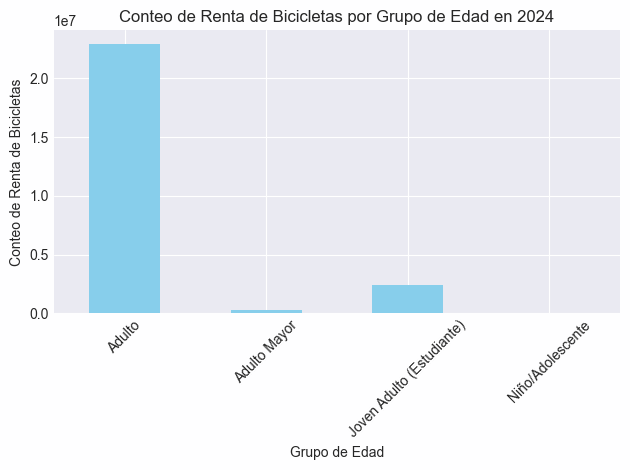

Conteo de Renta de Bicicletas por Grupo de Edad y Año:
age_group
Adulto                       22944142
Adulto Mayor                   270390
Joven Adulto (Estudiante)     2456459
Niño/Adolescente                 3381
Name: count, dtype: int64


In [22]:
# graficar y contar por grupo de edad de 2024
age_group_counts_2024 = df_sql_BikeRentalFact[df_sql_BikeRentalFact['year'] == 2024]['age_group'].value_counts().sort_index()
age_group_counts_2024.plot(kind='bar', color='skyblue', title='Conteo de Renta de Bicicletas por Grupo de Edad en 2024')
plt.xlabel('Grupo de Edad')
plt.ylabel('Conteo de Renta de Bicicletas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Conteo de Renta de Bicicletas por Grupo de Edad y Año:")
age_group_counts = df_sql_BikeRentalFact.groupby(['year', 'age_group']).size().unstack(fill_value=0)
print(age_group_counts_2024)

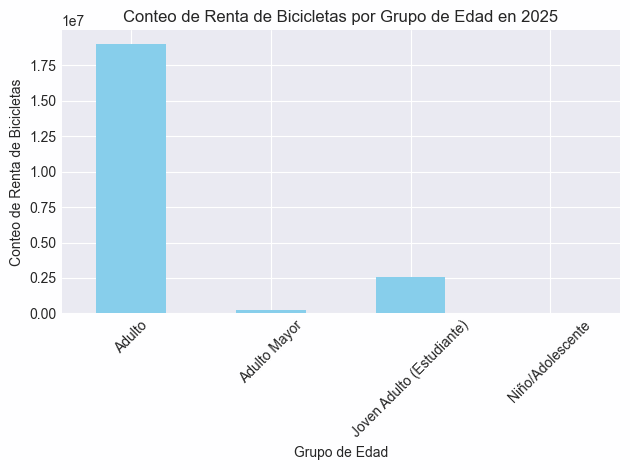

age_group
Adulto                       19010572
Adulto Mayor                   224972
Joven Adulto (Estudiante)     2585952
Niño/Adolescente                 7811
Name: count, dtype: int64


In [23]:
age_group_counts_2025 = df_sql_BikeRentalFact[df_sql_BikeRentalFact['year'] == 2025]['age_group'].value_counts().sort_index()
age_group_counts_2025.plot(kind='bar', color='skyblue', title='Conteo de Renta de Bicicletas por Grupo de Edad en 2025')
plt.xlabel('Grupo de Edad')
plt.ylabel('Conteo de Renta de Bicicletas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(age_group_counts_2025)

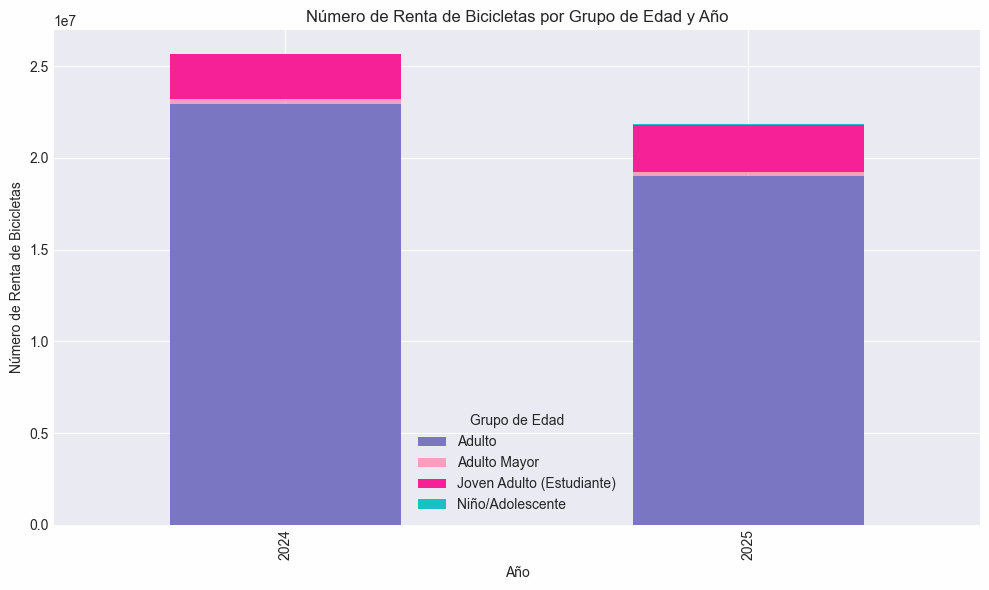

age_group,Adulto,Adulto Mayor,Joven Adulto (Estudiante),Niño/Adolescente
year,,,,
2024,22944142,270390,2456459,3381
2025,19010572,224972,2585952,7811


In [16]:
# agrupar y contar por grupo de edad por año
age_group_counts = df_sql_BikeRentalFact.groupby(['year', 'age_group']).size().unstack(fill_value=0)

age_group_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Número de Renta de Bicicletas por Grupo de Edad y Año')
plt.xlabel('Año')
plt.ylabel('Número de Renta de Bicicletas')
plt.legend(title='Grupo de Edad')
plt.tight_layout()
plt.show()

age_group_counts

In [17]:
# imprimir tabla de conteo
print("Conteo de Renta de Bicicletas por Grupo de Edad y Año:")
print(age_group_counts)


Conteo de Renta de Bicicletas por Grupo de Edad y Año:
age_group    Adulto  Adulto Mayor  Joven Adulto (Estudiante)  Niño/Adolescente
year                                                                          
2024       22944142        270390                    2456459              3381
2025       19010572        224972                    2585952              7811
